Rows loaded: 6613
Dataset summary:
- time_start: 1.096153352149
- time_end: 39.348043219546
- duration: 38.251889867397
- packets: 6613
- unique_senders: 170
- receiver: 10.0.0.172 (sinkNode)
- delay_min_s: 0.002017187874
- delay_max_s: 2.531721003967
- delay_mean_s: 0.23320795027214486
- delay_median_s: 0.216416252838

No duplicate (Sender, Packet ID) pairs detected as retransmissions proxy.

Per-sender potential retransmission-related outliers:
    Sender  outlier_count  outlier_threshold_s  max_delay_s
  10.0.0.1              2             0.677212     2.278658
 10.0.0.10              1             0.601108     1.256933
10.0.0.100              1             0.842090     1.336200
10.0.0.101              1             0.667208     1.118129
10.0.0.102              2             0.849781     2.349977
10.0.0.103              0             0.613595     0.387451
10.0.0.104              1             0.346268     0.357607
10.0.0.105              1             0.686180     1.332301
10.0.0.10

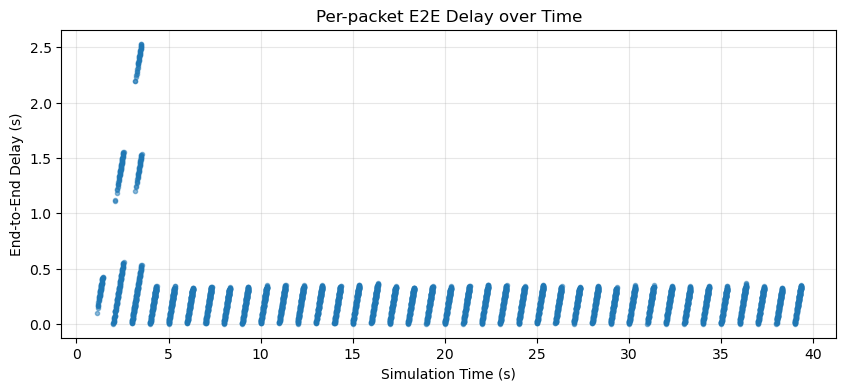

<Figure size 1000x400 with 0 Axes>

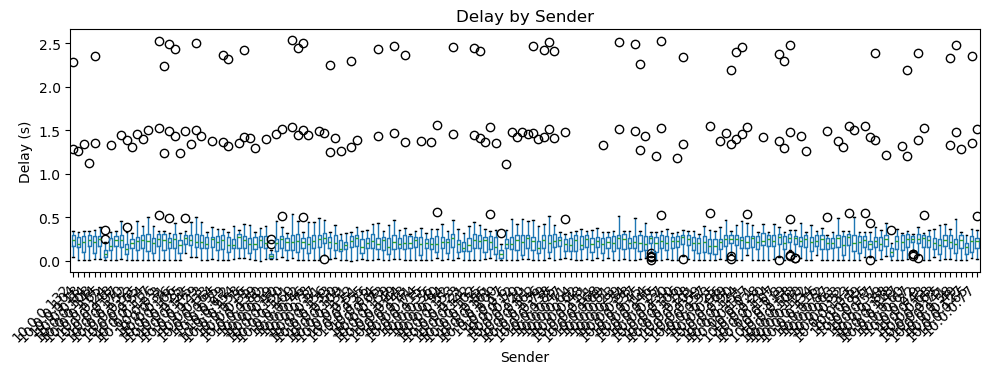

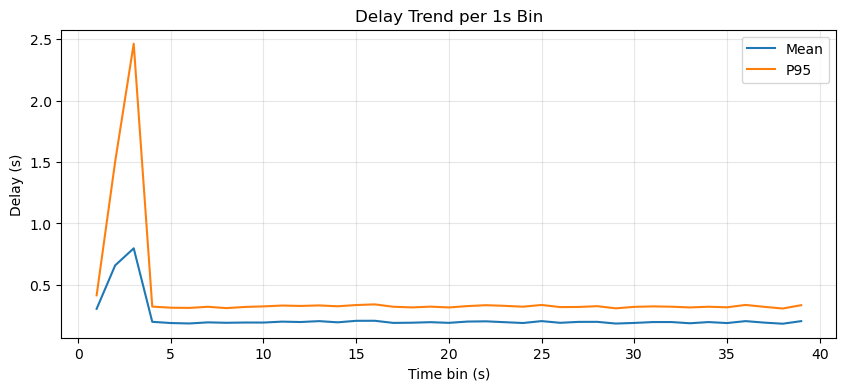

In [1]:
# -*- coding: utf-8 -*-
# Google Colab notebook: Analyze udpPacketTransmissionInfo.csv (per-packet E2E delay)
# - Computes per-sender stats (mean/median/std/jitter), per-run summary, and retransmission impact proxy
# - Visualizes delay over time and by sender (optional if matplotlib available)

# =============================
# 0) Setup
# =============================
import pandas as pd
import numpy as np
import io
import os

# Optional plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 4)

# =============================
# 1) Load CSV
# =============================
# If the file is already in Colab's working directory, set this to the filename.
CSV_PATH = 'udpPacketTransmissionInfo.csv'  # overwrite per run as noted

if not os.path.exists(CSV_PATH):
    from google.colab import files
    print('Upload udpPacketTransmissionInfo.csv')
    uploaded = files.upload()
    CSV_PATH = list(uploaded.keys())

# The CSV generated by simulation may contain lines with ellipses or merged rows.
# We'll use python engine and on_bad_lines='skip' to be robust.
df = pd.read_csv(CSV_PATH, engine='python', on_bad_lines='skip')

# Normalize column names
df.columns = [c.strip() for c in df.columns]
expected_cols = ['Simulation Time', 'Sender', 'Receiver', 'Packet ID', 'Delay']
missing = set(expected_cols) - set(df.columns)
if missing:
    raise ValueError(f'Missing expected columns: {missing}. Found columns: {df.columns.tolist()}')

# Coerce types
for col in ['Simulation Time', 'Delay']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['Packet ID'] = pd.to_numeric(df['Packet ID'], errors='coerce')
df = df.dropna(subset=['Simulation Time', 'Delay', 'Packet ID']).sort_values(['Simulation Time','Packet ID'])

print('Rows loaded:', len(df))
df.head()

# =============================
# 2) Basic dataset summary
# =============================
summary = {
    'time_start': df['Simulation Time'].min(),
    'time_end': df['Simulation Time'].max(),
    'duration': df['Simulation Time'].max() - df['Simulation Time'].min(),
    'packets': len(df),
    'unique_senders': df['Sender'].nunique(),
    'receiver': ','.join(sorted(df['Receiver'].astype(str).unique())),
    'delay_min_s': df['Delay'].min(),
    'delay_max_s': df['Delay'].max(),
    'delay_mean_s': df['Delay'].mean(),
    'delay_median_s': df['Delay'].median(),
}
print('Dataset summary:')
for k,v in summary.items():
    print(f'- {k}: {v}')

# =============================
# 3) Per-sender delay stats and jitter
# =============================
# Jitter (RFC 3550 style approximation): mean absolute inter-packet delay variation per sender.
# Compute inter-arrival differences in delay per sender over time.

def compute_jitter(g):
    g = g.sort_values('Simulation Time')
    if len(g) < 2:
        return np.nan
    delta = g['Delay'].diff().abs()
    return delta.dropna().mean()

per_sender = df.groupby('Sender').agg(
    packets=('Packet ID','count'),
    delay_min_s=('Delay','min'),
    delay_max_s=('Delay','max'),
    delay_mean_s=('Delay','mean'),
    delay_median_s=('Delay','median'),
    delay_std_s=('Delay','std'),
    jitter_mean_abs_s=('Delay', lambda s: compute_jitter(df.loc[s.index]))
).reset_index().sort_values('delay_mean_s')

#print('\nPer-sender stats:')
#print(per_sender.to_string(index=False))

# =============================
# 4) Retransmission impact proxy
# =============================
# The CSV logs successful packet arrivals with their E2E delay. It typically does not explicitly mark retransmissions.
# A practical proxy is to look for multiple arrivals with the same Packet ID from the same Sender, or unusually large delays.

# Detect duplicate (Sender, Packet ID) pairs which could indicate retransmits of the same logical packet id scheme.
duplicates = (df.duplicated(subset=['Sender','Packet ID'], keep=False))
dup_df = df[duplicates].sort_values(['Sender','Packet ID','Simulation Time'])

if dup_df.empty:
    print('\nNo duplicate (Sender, Packet ID) pairs detected as retransmissions proxy.')
else:
    print('\nPotential retransmissions detected (same Sender & Packet ID seen multiple times):')
    print(dup_df.to_string(index=False))

# Additionally, mark outlier delays (e.g., > median + 3*IQR) per sender which might be consistent with retransmission delays.
per_sender_outliers = []
for sender, g in df.groupby('Sender'):
    q1 = g['Delay'].quantile(0.25)
    q3 = g['Delay'].quantile(0.75)
    iqr = q3 - q1
    thresh = q3 + 3*iqr if iqr > 0 else g['Delay'].max()
    outliers = g[g['Delay'] > thresh]
    per_sender_outliers.append({
        'Sender': sender,
        'outlier_count': len(outliers),
        'outlier_threshold_s': float(thresh),
        'max_delay_s': float(g['Delay'].max())
    })
per_sender_outliers = pd.DataFrame(per_sender_outliers)
print('\nPer-sender potential retransmission-related outliers:')
print(per_sender_outliers.to_string(index=False))

# =============================
# 5) Time-binned delay distribution
# =============================
# Bin by 1-second windows to see whether mean/variance of delay increases over time.

df['time_bin_s'] = np.floor(df['Simulation Time']).astype(int)
by_bin = df.groupby('time_bin_s').agg(
    packets=('Packet ID','count'),
    delay_mean_s=('Delay','mean'),
    delay_std_s=('Delay','std'),
    delay_p95_s=('Delay', lambda s: s.quantile(0.95)),
).reset_index()
print('\nPer-1s bin stats:')
print(by_bin.head(20).to_string(index=False))

# =============================
# 6) Visualizations (optional)
# =============================
try:
    # Delay over time
    plt.figure()
    plt.plot(df['Simulation Time'], df['Delay'], '.', alpha=0.5)
    plt.xlabel('Simulation Time (s)')
    plt.ylabel('End-to-End Delay (s)')
    plt.title('Per-packet E2E Delay over Time')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Delay by sender (boxplot)
    plt.figure()
    order = df.groupby('Sender')['Delay'].median().sort_values().index
    df.boxplot(column='Delay', by='Sender', positions=np.arange(len(order)),
               widths=0.6, grid=False)
    plt.xticks(range(len(order)), order, rotation=45, ha='right')
    plt.suptitle('')
    plt.title('Delay by Sender')
    plt.ylabel('Delay (s)')
    plt.tight_layout()
    plt.show()

    # Bin trends
    plt.figure()
    plt.plot(by_bin['time_bin_s'], by_bin['delay_mean_s'], label='Mean')
    plt.plot(by_bin['time_bin_s'], by_bin['delay_p95_s'], label='P95')
    plt.xlabel('Time bin (s)')
    plt.ylabel('Delay (s)')
    plt.title('Delay Trend per 1s Bin')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
except Exception as e:
    print('Plotting skipped or failed:', e)

# =============================
# 7) Save key outputs as CSVs
# =============================



In [2]:
# -*- coding: utf-8 -*-
# Google Colab: Estimate MAC-layer retransmission rate from cwUsed.csv
# Assumptions (typical 802.11-style CW progression):
# - CW starts at a minimum (e.g., 15) for a new attempt.
# - Upon failed transmission (collision/corruption), CW doubles up to a max (e.g., 31, 63, 127, ... depending on config).
# - Each step-up event indicates at least one retransmission attempt was needed.
# This script treats increases in CW for a node within a short time window as retransmission evidence and estimates rate.

import pandas as pd
import numpy as np
import os

CSV_PATH = 'cwUsed.csv'
if not os.path.exists(CSV_PATH):
    try:
        from google.colab import files
        print('Upload cwUsed.csv')
        uploaded = files.upload()
        CSV_PATH = list(uploaded.keys())
    except Exception:
        pass

# Load CSV (robust to minor formatting issues)
df = pd.read_csv(CSV_PATH, engine='python', on_bad_lines='skip')
df.columns = [c.strip() for c in df.columns]
# Some files may have a typo like 'Contetion Size' instead of 'Contention Size'
if 'Contention Size' in df.columns:
    cw_col = 'Contention Size'
elif 'Contetion Size' in df.columns:
    cw_col = 'Contetion Size'
else:
    raise ValueError('Missing contention window column (expected Contention Size or Contetion Size). Found: ' + str(df.columns))

# Coerce types and clean
num_cols = ['Simulation Time']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

df[cw_col] = pd.to_numeric(df[cw_col], errors='coerce')
df = df.dropna(subset=['Simulation Time', 'Node', cw_col]).sort_values(['Node','Simulation Time'])

# Identify CW step-up events per node (proxy for retransmissions)
# A step-up occurs when CW(t) > CW(t-1) for the same node.
# Optional: collapse rapid toggles within a small window as a single episode.
MERGE_WINDOW_S = 0.01  # merge CW increases occurring within 10 ms as one backoff episode

results = []

for node, g in df.groupby('Node'):
    g = g.sort_values('Simulation Time').copy()
    g['cw_prev'] = g[cw_col].shift(1)
    g['t_prev'] = g['Simulation Time'].shift(1)
    g['step_up'] = (g[cw_col] > g['cw_prev'])

    # Count raw step-ups
    stepups = g[g['step_up']].copy()

    # Merge close step-ups into episodes
    episodes = []
    current = None
    for _, r in stepups.iterrows():
        t = r['Simulation Time']
        if current is None:
            current = {'start': t, 'end': t, 'count': 1}
        else:
            if t - current['end'] <= MERGE_WINDOW_S:
                current['end'] = t
                current['count'] += 1
            else:
                episodes.append(current)
                current = {'start': t, 'end': t, 'count': 1}
    if current is not None:
        episodes.append(current)

    # Compute node-level metrics
    total_time = g['Simulation Time'].max() - g['Simulation Time'].min() if len(g) > 1 else np.nan
    retransmissions = len(episodes)  # episodes as retransmission occurrences
    raw_stepups = len(stepups)

    # Estimate number of attempts: count times CW returns to minimum after being larger
    cw_min = g[cw_col].min()
    # A new TX attempt can be proxied by transitions to cw_min from a higher CW, or any record at cw_min following non-cw_min
    g['is_min'] = (g[cw_col] == cw_min)
    g['was_min_prev'] = g['is_min'].shift(1).fillna(False)
    g['was_higher_prev'] = (g['cw_prev'] > cw_min).fillna(False)
    new_attempts = int(((g['is_min'] & (g['was_higher_prev'] | (~g['was_min_prev']))).sum()))
    # Fallback if too low: also consider each second boundary min as new attempt if logs are periodic
    if new_attempts == 0:
        # count unique integer-second bins with cw at min as attempts
        bins = np.floor(g.loc[g['is_min'], 'Simulation Time']).astype(int).nunique()
        new_attempts = int(bins)

    rate_per_sec = (retransmissions / total_time) if total_time and total_time > 0 else np.nan

    results.append({
        'Node': node,
        'cw_min': int(cw_min),
        'raw_stepups': int(raw_stepups),
        'retransmission_episodes': int(retransmissions),
        'estimated_attempts': int(new_attempts),
        'retransmission_rate_per_sec': float(rate_per_sec),
        'observation_time_s': float(total_time),
    })

res = pd.DataFrame(results).sort_values('Node')
print('Per-node MAC-layer retransmission proxy metrics:')
print(res.to_string(index=False))

# Aggregate overall metrics
overall = {
    'nodes': res['Node'].nunique(),
    'total_retransmission_episodes': int(res['retransmission_episodes'].sum()),
    'total_raw_stepups': int(res['raw_stepups'].sum()),
    'total_estimated_attempts': int(res['estimated_attempts'].sum()),
}
# Overall retransmission fraction = episodes / attempts (proxy)
if overall['total_estimated_attempts'] > 0:
    overall['retransmission_fraction'] = overall['total_retransmission_episodes'] / overall['total_estimated_attempts']
else:
    overall['retransmission_fraction'] = np.nan

print('\nOverall proxies:')
for k,v in overall.items():
    print(f'- {k}: {v}')




/tmp/ipykernel_32203/2453899632.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  g['was_min_prev'] = g['is_min'].shift(1).fillna(False)
/tmp/ipykernel_32203/2453899632.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  g['was_min_prev'] = g['is_min'].shift(1).fillna(False)
/tmp/ipykernel_32203/2453899632.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silen

Per-node MAC-layer retransmission proxy metrics:
             Node  cw_min  raw_stepups  retransmission_episodes  estimated_attempts  retransmission_rate_per_sec  observation_time_s
      accessPoint      31            9                        8                  10                     0.200501           39.900000
  wirelessHost[0]      15          145                      132                  41                     3.313562           39.836280
wirelessHost[100]      15          148                      131                  41                     3.302229           39.670175
wirelessHost[101]      15          122                      106                  40                     2.675167           39.623693
wirelessHost[102]      15          144                      135                  40                     3.395827           39.754675
wirelessHost[103]      15           79                       73                  40                     1.835546           39.770180
wirelessHost[104]   

/tmp/ipykernel_32203/2453899632.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  g['was_min_prev'] = g['is_min'].shift(1).fillna(False)
/tmp/ipykernel_32203/2453899632.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  g['was_min_prev'] = g['is_min'].shift(1).fillna(False)
/tmp/ipykernel_32203/2453899632.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silen

In [3]:
import pandas as pd
import numpy as np

# Input/output filenames
HEADER_FILE = 'HeaderErrorRate.csv'
DATA_FILE = 'DataErrorRate.csv'
OUT_MERGED = 'PacketErrorRates_Merged.csv'
OUT_SUMMARY = 'PacketErrorRates_Summary.csv'         # per-node BER + SNIR stats (min/median/mean/max)
OUT_SNR_SUMMARY = 'SNIR_By_Node_Summary.csv'         # kept for compatibility; now same SNIR stats subset
OUT_OVERALL = 'PacketErrorRates_Overall.csv'         # overall (all nodes combined) stats

# Load input CSVs
header_df = pd.read_csv(HEADER_FILE)
data_df = pd.read_csv(DATA_FILE)

# Clean/normalize headers
header_df.columns = [c.strip().replace('\u00a0',' ').replace('\ufeff','') for c in header_df.columns]
data_df.columns = [c.strip().replace('\u00a0',' ').replace('\ufeff','') for c in data_df.columns]

# Rename for clarity
header_df = header_df.rename(columns={
    'Header Length':'HeaderLength',
    'Error rate':'HeaderBER'
})
data_df = data_df.rename(columns={
    'Data Length':'DataLength',
    'Error rate':'DataBER'
})

# Ensure numeric types
for col in ['Simulation Time','SNIR','HeaderLength','HeaderBER']:
    if col in header_df.columns:
        header_df[col] = pd.to_numeric(header_df[col], errors='coerce')
for col in ['Simulation Time','SNIR','DataLength','DataBER']:
    if col in data_df.columns:
        data_df[col] = pd.to_numeric(data_df[col], errors='coerce')

# Drop exact duplicate lines to avoid double counting
header_df = header_df.drop_duplicates(subset=['Simulation Time','Node','HeaderLength','HeaderBER','SNIR'])
data_df = data_df.drop_duplicates(subset=['Simulation Time','Node','DataLength','DataBER','SNIR'])

# Pair header and data by Simulation Time + Node + SNIR
merged = pd.merge_asof(
    header_df.sort_values('Simulation Time'),
    data_df.sort_values('Simulation Time'),
    on='Simulation Time',
    by=['Node','SNIR'],
    direction='nearest',
    tolerance=1e-9
)

# Keep only fully matched rows
merged = merged.dropna(subset=['HeaderLength','DataLength','HeaderBER','DataBER','SNIR'])

# Compute total bits and packet-level BER as length-weighted average
merged['TotalBits'] = merged['HeaderLength'] + merged['DataLength']
merged = merged[merged['TotalBits'] > 0]
merged['PacketBER'] = (merged['HeaderBER']*merged['HeaderLength'] + merged['DataBER']*merged['DataLength']) / merged['TotalBits']

# Reorder and sort
cols = ['Simulation Time','Node','SNIR','HeaderLength','HeaderBER','DataLength','DataBER','TotalBits','PacketBER']
merged = merged[cols].sort_values(['Simulation Time','Node']).reset_index(drop=True)

# Write detailed merged per-packet CSV
merged.to_csv(OUT_MERGED, index=False)

# Helper to build min/median/mean/max spec for a column with a prefix
def stat_block(col, prefix):
    return {
        f'{prefix}_min': (col, 'min'),
        f'{prefix}_median': (col, 'median'),
        f'{prefix}_avg': (col, 'mean'),
        f'{prefix}_max': (col, 'max'),
    }

# Per-node metrics: BER (header/data/packet) + SNIR
agg_spec = {}
agg_spec.update(stat_block('HeaderBER', 'header_ber'))
agg_spec.update(stat_block('DataBER', 'data_ber'))
agg_spec.update(stat_block('PacketBER', 'packet_ber'))
agg_spec.update(stat_block('SNIR', 'snir'))

summary = merged.groupby('Node').agg(**agg_spec)

# Optional: also include packet counts per node
summary['packets'] = merged.groupby('Node')['PacketBER'].size()

# Save per-node summary
summary.to_csv(OUT_SUMMARY)

# Maintain the SNIR-only summary file for compatibility, now min/median/avg/max
snr_summary = merged.groupby('Node').agg(
    min_snir=('SNIR','min'),
    median_snir=('SNIR','median'),
    avg_snir=('SNIR','mean'),
    max_snir=('SNIR','max'),
    packets=('SNIR','size')
)
snr_summary.to_csv(OUT_SNR_SUMMARY)

# Overall (all nodes combined) stats across entire dataset
overall = pd.DataFrame({
    'header_ber_min': [merged['HeaderBER'].min()],
    'header_ber_median': [merged['HeaderBER'].median()],
    'header_ber_avg': [merged['HeaderBER'].mean()],
    'header_ber_max': [merged['HeaderBER'].max()],
    'data_ber_min': [merged['DataBER'].min()],
    'data_ber_median': [merged['DataBER'].median()],
    'data_ber_avg': [merged['DataBER'].mean()],
    'data_ber_max': [merged['DataBER'].max()],
    'packet_ber_min': [merged['PacketBER'].min()],
    'packet_ber_median': [merged['PacketBER'].median()],
    'packet_ber_avg': [merged['PacketBER'].mean()],
    'packet_ber_max': [merged['PacketBER'].max()],
    'snir_min': [merged['SNIR'].min()],
    'snir_median': [merged['SNIR'].median()],
    'snir_avg': [merged['SNIR'].mean()],
    'snir_max': [merged['SNIR'].max()],
    'packets': [len(merged)]
})
overall.to_csv(OUT_OVERALL, index=False)

# print('Per-node packet-level BER and SNIR stats (min/median/avg/max):')
# for index, row in summary.iterrows():
#     print(f"\nNode: {index}")
#     for col, value in row.items():
#         print(f"- {col}: {value}")

print('\nOverall stats (all nodes):')
for index, row in overall.iterrows():
    for col, value in row.items():
        print(f"- {col}: {value}")

FileNotFoundError: [Errno 2] No such file or directory: 'HeaderErrorRate.csv'